In [1]:
from pyspark.sql import SparkSession
from operator import add

spark_session = SparkSession.builder\
        .master("spark://192.168.2.186:7077") \
        .appName("sarthak-app")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", 2)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext

spark_context.setLogLevel("INFO")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/07 20:47:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load dataset
df = spark_session.read.json("hdfs://localhost:9000/corpus-webis-tldr-17.json")


24/03/07 20:47:22 INFO SharedState: Setting hive.metastore.warehouse.dir ('null') to the value of spark.sql.warehouse.dir.
24/03/07 20:47:22 INFO SharedState: Warehouse path is 'file:/home/ubuntu/spark-warehouse'.
24/03/07 20:47:23 INFO InMemoryFileIndex: It took 114 ms to list leaf files for 1 paths.
24/03/07 20:47:23 INFO InMemoryFileIndex: It took 24 ms to list leaf files for 1 paths.
24/03/07 20:47:26 INFO FileSourceStrategy: Pushed Filters: 
24/03/07 20:47:26 INFO FileSourceStrategy: Post-Scan Filters: 
24/03/07 20:47:26 INFO MemoryStore: Block broadcast_0 stored as values in memory (estimated size 351.3 KiB, free 366.0 MiB)
24/03/07 20:47:26 INFO MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 34.6 KiB, free 365.9 MiB)
24/03/07 20:47:26 INFO BlockManagerInfo: Added broadcast_0_piece0 in memory on de-22-master-02:10005 (size: 34.6 KiB, free: 366.3 MiB)
24/03/07 20:47:26 INFO SparkContext: Created broadcast 0 from json at NativeMethodAccessorImpl.jav

In [3]:
import time

# Dictionary to store execution times
execution_times = {}

def measure_execution_time(job_name, job_function):
    start_time = time.time()
    
    # Execute the Spark job function
    job_function()
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Store the execution time using the job name as the key
    execution_times[job_name] = execution_time
    print(f"Execution time for {job_name}: {execution_time} seconds")

In [4]:
from pyspark.sql.functions import col

# What are the most popular subreddits based on the number of posts?
def job_popular_subreddits():
    # Placeholder for Spark code to find the most popular subreddits
    # Count posts per subreddit
    subreddit_counts = df.groupBy("subreddit").count().orderBy(col("count").desc())

    subreddit_counts.show()

In [5]:
from pyspark.sql.functions import avg

# What is the average length of content and summary across all posts?
def job_average_lengths():
    # Calculate average content and summary length
    avg_lengths = df.select(
        avg(col("content_len")).alias("avg_content_length"),
        avg(col("summary_len")).alias("avg_summary_length")
    )
    
    avg_lengths.show()

In [6]:
# Which posts have the highest engagement based on content length?
def job_highest_engagement():
    # Assuming 'engagement' can be inferred from content length or a specific field is present to denote engagement
    df.orderBy(col("content_len").desc()).limit(10).show()

In [7]:
# Can we identify any correlation between content length and summary length?
def job_content_summary_correlation():
    # Calculate correlation between 'content_len' and 'summary_len'
    print(df.stat.corr("content_len", "summary_len"))

In [8]:
# What are the most common words or topics in the content and summaries of the top N subreddits?
from pyspark.sql.functions import explode, split

def job_common_words_top_subreddits():
    # First, identify the top N subreddits by post count
    top_subreddits = df.groupBy("subreddit").count().orderBy(col("count").desc()).limit(100)
    
    # Filter posts from these top subreddits
    top_subreddit_posts = df.join(top_subreddits, "subreddit")
    
    # Split words in content and explode the resulting arrays to analyze word frequency
    words_df = top_subreddit_posts.select(explode(split(col("content"), " ")).alias("word"))
    word_counts = words_df.groupBy("word").count().orderBy(col("count").desc())
    
    word_counts.show()

In [9]:
measure_execution_time("Popular Subreddits", job_popular_subreddits)
measure_execution_time("Average Lengths", job_average_lengths)
measure_execution_time("Highest Engagement", job_highest_engagement)
measure_execution_time("Content-Summary Correlation", job_content_summary_correlation)
measure_execution_time("Common Words in Top Subreddits", job_common_words_top_subreddits)

24/03/07 20:48:32 INFO FileSourceStrategy: Pushed Filters: 
24/03/07 20:48:32 INFO FileSourceStrategy: Post-Scan Filters: 
24/03/07 20:48:33 INFO CodeGenerator: Code generated in 320.05761 ms
24/03/07 20:48:33 INFO MemoryStore: Block broadcast_2 stored as values in memory (estimated size 351.2 KiB, free 365.6 MiB)
24/03/07 20:48:33 INFO MemoryStore: Block broadcast_2_piece0 stored as bytes in memory (estimated size 34.5 KiB, free 365.5 MiB)
24/03/07 20:48:33 INFO BlockManagerInfo: Added broadcast_2_piece0 in memory on de-22-master-02:10005 (size: 34.5 KiB, free: 366.2 MiB)
24/03/07 20:48:33 INFO SparkContext: Created broadcast 2 from showString at NativeMethodAccessorImpl.java:0
24/03/07 20:48:33 INFO FileSourceScanExec: Planning scan with bin packing, max size: 134217728 bytes, open cost is considered as scanning 4194304 bytes.
24/03/07 20:48:33 INFO DAGScheduler: Registering RDD 7 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 0
24/03/07 20:48:33 INFO DAGSchedule

+-------------------+------+
|          subreddit| count|
+-------------------+------+
|          AskReddit|589947|
|      relationships|352049|
|    leagueoflegends|109307|
|               tifu| 52219|
|relationship_advice| 50416|
|              trees| 47286|
|             gaming| 43851|
|            atheism| 43268|
|      AdviceAnimals| 40783|
|              funny| 40171|
|           politics| 36518|
|               pics| 35098|
|                sex| 28806|
|                WTF| 25781|
|  explainlikeimfive| 25482|
|      todayilearned| 25004|
|            Fitness| 22694|
|               IAmA| 22689|
|          worldnews| 22577|
|              DotA2| 22405|
+-------------------+------+
only showing top 20 rows

Execution time for Popular Subreddits: 57.57132959365845 seconds


24/03/07 20:49:29 INFO CodeGenerator: Code generated in 16.242893 ms
24/03/07 20:49:29 INFO MemoryStore: Block broadcast_5 stored as values in memory (estimated size 351.2 KiB, free 365.1 MiB)
24/03/07 20:49:29 INFO MemoryStore: Block broadcast_5_piece0 stored as bytes in memory (estimated size 34.5 KiB, free 365.0 MiB)
24/03/07 20:49:29 INFO BlockManagerInfo: Added broadcast_5_piece0 in memory on de-22-master-02:10005 (size: 34.5 KiB, free: 366.2 MiB)
24/03/07 20:49:29 INFO SparkContext: Created broadcast 5 from showString at NativeMethodAccessorImpl.java:0
24/03/07 20:49:29 INFO FileSourceScanExec: Planning scan with bin packing, max size: 134217728 bytes, open cost is considered as scanning 4194304 bytes.
24/03/07 20:49:29 INFO DAGScheduler: Registering RDD 15 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 1
24/03/07 20:49:29 INFO DAGScheduler: Got map stage job 3 (showString at NativeMethodAccessorImpl.java:0) with 147 output partitions
24/03/07 20:49:29 INFO D

+------------------+------------------+
|avg_content_length|avg_summary_length|
+------------------+------------------+
|271.93096278125836| 26.16961902955308|
+------------------+------------------+

Execution time for Average Lengths: 50.190826654434204 seconds


24/03/07 20:50:19 INFO BlockManagerInfo: Added broadcast_8_piece0 in memory on 192.168.2.186:10007 (size: 34.5 KiB, free: 366.2 MiB)
24/03/07 20:50:19 INFO BlockManagerInfo: Added broadcast_8_piece0 in memory on 192.168.2.186:10009 (size: 34.5 KiB, free: 366.2 MiB)
24/03/07 20:50:19 INFO BlockManagerInfo: Added broadcast_8_piece0 in memory on 192.168.2.186:10013 (size: 34.5 KiB, free: 366.2 MiB)
24/03/07 20:50:19 INFO BlockManagerInfo: Added broadcast_8_piece0 in memory on 192.168.2.186:10008 (size: 34.5 KiB, free: 366.2 MiB)
24/03/07 20:50:19 INFO BlockManagerInfo: Added broadcast_8_piece0 in memory on 192.168.2.186:10012 (size: 34.5 KiB, free: 366.2 MiB)
24/03/07 20:50:19 INFO BlockManagerInfo: Added broadcast_8_piece0 in memory on 192.168.2.186:10011 (size: 34.5 KiB, free: 366.2 MiB)
24/03/07 20:50:19 INFO BlockManagerInfo: Added broadcast_8_piece0 in memory on 192.168.2.186:10010 (size: 34.5 KiB, free: 366.2 MiB)
24/03/07 20:50:19 INFO BlockManagerInfo: Added broadcast_8_piece0 in 

+--------------------+--------------------+--------------------+-----------+---------+--------------------+---------------+------------+--------------------+-----------+--------------------+
|              author|                body|             content|content_len|       id|      normalizedBody|      subreddit|subreddit_id|             summary|summary_len|               title|
+--------------------+--------------------+--------------------+-----------+---------+--------------------+---------------+------------+--------------------+-----------+--------------------+
|         Didimeister|Why Why Why Why W...|Why Why Why Why W...|       9952|t3_47qsqx|Why Why Why Why W...| LibraryofBabel|    t5_2s9w8|never focus on th...|         20|          ELI5: Why?|
|           [deleted]|all dank and no d...|all dank and no d...|       8173|t3_2taunn|all dank and no d...|     circlejerk|    t5_2qpol|           VERY DANK|          2|all dank and no d...|
|           [deleted]|So, i have a long...|So

24/03/07 20:51:15 INFO FileSourceStrategy: Pushed Filters: 
24/03/07 20:51:15 INFO FileSourceStrategy: Post-Scan Filters: 
24/03/07 20:51:15 INFO CodeGenerator: Code generated in 30.833275 ms
24/03/07 20:51:15 INFO MemoryStore: Block broadcast_10 stored as values in memory (estimated size 351.2 KiB, free 365.6 MiB)
24/03/07 20:51:15 INFO MemoryStore: Block broadcast_10_piece0 stored as bytes in memory (estimated size 34.5 KiB, free 365.5 MiB)
24/03/07 20:51:15 INFO BlockManagerInfo: Added broadcast_10_piece0 in memory on de-22-master-02:10005 (size: 34.5 KiB, free: 366.2 MiB)
24/03/07 20:51:15 INFO SparkContext: Created broadcast 10 from corr at NativeMethodAccessorImpl.java:0
24/03/07 20:51:15 INFO FileSourceScanExec: Planning scan with bin packing, max size: 134217728 bytes, open cost is considered as scanning 4194304 bytes.
24/03/07 20:51:15 INFO DAGScheduler: Registering RDD 26 (corr at NativeMethodAccessorImpl.java:0) as input to shuffle 2
24/03/07 20:51:15 INFO DAGScheduler: Got 

0.32662756906663004
Execution time for Content-Summary Correlation: 78.40455174446106 seconds


24/03/07 20:52:34 INFO BlockManagerInfo: Removed broadcast_9_piece0 on 192.168.2.186:10013 in memory (size: 7.1 KiB, free: 366.2 MiB)
24/03/07 20:52:34 INFO BlockManagerInfo: Removed broadcast_9_piece0 on 192.168.2.186:10009 in memory (size: 7.1 KiB, free: 366.2 MiB)
24/03/07 20:52:34 INFO BlockManagerInfo: Removed broadcast_9_piece0 on 192.168.2.186:10010 in memory (size: 7.1 KiB, free: 366.2 MiB)
24/03/07 20:52:34 INFO BlockManagerInfo: Removed broadcast_9_piece0 on 192.168.2.186:10008 in memory (size: 7.1 KiB, free: 366.2 MiB)
24/03/07 20:52:34 INFO BlockManagerInfo: Removed broadcast_9_piece0 on 192.168.2.186:10011 in memory (size: 7.1 KiB, free: 366.2 MiB)
24/03/07 20:52:34 INFO BlockManagerInfo: Removed broadcast_9_piece0 on 192.168.2.186:10006 in memory (size: 7.1 KiB, free: 366.2 MiB)
24/03/07 20:52:34 INFO BlockManagerInfo: Removed broadcast_9_piece0 on 192.168.2.186:10007 in memory (size: 7.1 KiB, free: 366.2 MiB)
24/03/07 20:52:34 INFO BlockManagerInfo: Removed broadcast_9_p

+----+--------+
|word|   count|
+----+--------+
|   I|21772577|
| the|21371259|
|  to|20370477|
| and|19591881|
|   a|15566019|
|  of|11112888|
|  \n| 9323606|
|that| 8404942|
|  in| 7778927|
|  my| 7162255|
| was| 6725528|
|  is| 6225561|
| for| 5952877|
|  it| 5789218|
|    | 5659071|
|with| 5334123|
|  me| 4367853|
| but| 4345200|
|  on| 4274986|
|have| 4207031|
+----+--------+
only showing top 20 rows

Execution time for Common Words in Top Subreddits: 173.5696816444397 seconds


24/03/07 20:55:27 INFO TaskSetManager: Finished task 0.0 in stage 17.0 (TID 1052) in 8209 ms on 192.168.2.186 (executor 1) (17/17)
24/03/07 20:55:27 INFO TaskSchedulerImpl: Removed TaskSet 17.0, whose tasks have all completed, from pool 
24/03/07 20:55:27 INFO DAGScheduler: ResultStage 17 (showString at NativeMethodAccessorImpl.java:0) finished in 8.216 s
24/03/07 20:55:27 INFO DAGScheduler: Job 11 is finished. Cancelling potential speculative or zombie tasks for this job
24/03/07 20:55:27 INFO TaskSchedulerImpl: Killing all running tasks in stage 17: Stage finished
24/03/07 20:55:27 INFO DAGScheduler: Job 11 finished: showString at NativeMethodAccessorImpl.java:0, took 8.238142 s
24/03/07 20:55:27 INFO CodeGenerator: Code generated in 12.219189 ms            


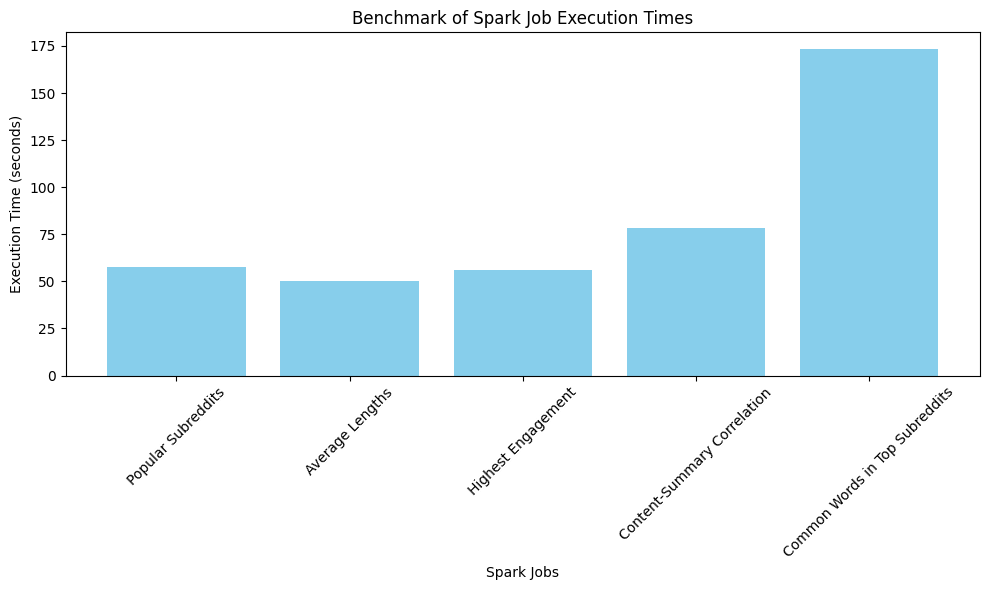

In [10]:
import matplotlib.pyplot as plt

# Names and times for plotting
jobs = list(execution_times.keys())
times = list(execution_times.values())

plt.figure(figsize=(10, 6))
plt.bar(jobs, times, color='skyblue')
plt.xlabel('Spark Jobs')
plt.ylabel('Execution Time (seconds)')
plt.title('Benchmark of Spark Job Execution Times')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()